# Classificação de Texto com LSTM

Neste notebook, exploraremos a aplicação de Redes Neurais Recorrentes (RNNs) do tipo Long Short-Term Memory (LSTM) para a classificação de textos em 10 categorias distintas. Utilizaremos o dataset *20 Newsgroups*, um padrão para benchmarks em Processamento de Linguagem Natural (PLN). O foco principal será a construção de um pipeline de processamento que transforma texto bruto em representações vetoriais densas (embeddings), que são então processadas sequencialmente pela LSTM para capturar dependências temporais e semânticas, superando limitações de modelos tradicionais baseados em frequência de palavras.

In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.datasets import fetch_20newsgroups
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo selecionado: {device}')

## Preparação dos Dados

Para o processamento de texto em redes neurais profundas, devemos converter as strings em tensores numéricos. Diferente de abordagens complexas de tokenização como BPE ou WordPiece, utilizaremos uma abordagem determinística baseada na separação por espaços e conversão para minúsculas. Isso simplifica o vocabulário, embora possa gerar um número maior de tokens desconhecidos (`<unk>`).

Selecionaremos um subconjunto de 10 categorias para o treinamento. O processo envolve a criação de um vocabulário que mapeia cada palavra única para um índice inteiro. Palavras raras ou fora do vocabulário de treino serão mapeadas para um token especial `<unk>`, e as sequências serão preenchidas com `<pad>` para garantir uniformidade dimensional nos lotes.

In [ ]:
# Categorias selecionadas
categories = [
    'sci.med', 'talk.politics.mideast', 'comp.graphics'
]

# Carregamento do dataset original
train_source = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
test_source = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

train_data = train_source.data
train_labels = train_source.target
test_data = test_source.data
test_labels = test_source.target

print(f"Amostras de treino: {len(train_data)}")
print(f"Amostras de teste: {len(test_data)}")

In [ ]:
def show_examples(data, labels, target_names, n=3, max_chars=200):
    classes = np.unique(labels)
    for c in classes:
        print("="*80)
        print(f"CLASSE: {target_names[c]}")
        print("="*80)

        idxs = np.where(labels == c)[0]
        chosen = np.random.choice(idxs, size=min(n, len(idxs)), replace=False)

        for i, idx in enumerate(chosen, 1):
            text = data[idx].strip().replace("\n", " ")
            if len(text) > max_chars:
                text = text[:max_chars] + "..."
            
            print(f"\n--- Exemplo {i} ---")
            print(text)
        print("\n")

show_examples(train_data, train_labels, train_source.target_names, n=3)

In [ ]:
token_pattern = re.compile(r"\b\w+\b", flags=re.UNICODE)

def simple_tokenizer(text, max_len=300):
    tokens = token_pattern.findall(text.lower())
    return tokens[:max_len]

# Construção do Vocabulário
token_counts = Counter()
for text in train_data:
    token_counts.update(simple_tokenizer(text))

# Definição de índices especiais
vocab = {"<pad>": 0, "<unk>": 1}
min_freq = 2

for word, count in token_counts.items():
    if count >= min_freq:
        vocab[word] = len(vocab)

print(f"Tamanho final do vocabulário: {len(vocab)}")

### Dataset e DataLoaders

No PyTorch, a classe `Dataset` deve implementar os métodos `__len__` e `__getitem__`. No método `__getitem__`, realizamos a conversão imediata do texto cru para uma lista de índices baseada no vocabulário construído anteriormente.

A função `collate_fn` é importante em modelos de sequência. Como as frases têm comprimentos variados, não podemos simplesmente empilhá-las em um tensor retangular. Esta função preenche (*pads*) as sequências mais curtas com o índice 0 (`<pad>`) até atingirem o comprimento da maior sequência presente no lote atual.

In [ ]:
class NewsGroupDataset(Dataset):
    def __init__(self, data, targets, vocab, tokenizer):
        self.data = data
        self.targets = targets
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        tokens = self.tokenizer(text)
        # Mapeia token para índice, usa <unk> se não existir
        indices = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
        
        # Garante que não haja sequências vazias
        if len(indices) == 0:
            indices = [self.vocab["<unk>"]]
            
        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

In [ ]:
# Hiperparâmetros de carregamento
batch_size = 32

train_dataset = NewsGroupDataset(train_data, train_labels, vocab, simple_tokenizer)
test_dataset = NewsGroupDataset(test_data, test_labels, vocab, simple_tokenizer)

In [ ]:
def collate_batch(batch):
    labels = []
    text_list = []
    
    for (_text_indices, _label) in batch:
        labels.append(_label)
        text_list.append(_text_indices)
    
    # Pad sequences para que todos tenham o mesmo tamanho no batch
    # padding_value=0 corresponde ao nosso <pad>
    text_padded = pad_sequence(text_list, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return text_padded.to(device), labels.to(device)
    
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

## Implementação do Modelo

A arquitetura inicia-se com uma camada `nn.Embedding`. Matematicamente, ela funciona como uma tabela de consulta $E \in \mathbb{R}^{|V| \times d}$, onde $|V|$ é o tamanho do vocabulário e $d$ a dimensão do embedding. Dado um índice de palavra $w$, a saída é o vetor $v_w$. Isso permite que a rede aprenda representações semânticas densas, onde palavras com significados similares estão geometricamente próximas.

Em seguida, temos a camada LSTM (Long Short-Term Memory). A LSTM resolve o problema do desvanecimento do gradiente através de um estado de célula $C_t$ que carrega informação por longos períodos, controlado por portões (*gates*).

In [178]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout_prob):
        super().__init__()
        
        # Camada de Embedding: padding_idx=0 garante que o vetor do <pad> seja sempre zero e não treinado
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Camada LSTM
        self.lstm = nn.LSTM(input_size=embed_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=n_layers, 
                            batch_first=True, 
                            dropout=dropout_prob if n_layers > 1 else 0)
        
        # Camada Linear de Saída
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))

        lengths = (text != 0).sum(dim=1).cpu()
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths, batch_first=True, enforce_sorted=False
        )

        _, (hidden, _) = self.lstm(packed)
        last_hidden = hidden[-1]

        output = self.fc(self.dropout(last_hidden))
        return output

## Treinamento

Nesta etapa, instanciamos o modelo e definimos a função de custo (`CrossEntropyLoss`) e o otimizador (`Adam`). A função de custo `CrossEntropyLoss` no PyTorch combina `LogSoftmax` e `NLLLoss`, sendo ideal para classificação multiclasse onde a saída da rede são *logits* (valores não normalizados).

O loop de treinamento itera sobre o dataset, calcula o gradiente da perda em relação aos parâmetros e atualiza os pesos. O loop de avaliação monitora a generalização do modelo nos dados de teste sem atualizar os gradientes (`torch.no_grad()`).

In [179]:
# Definição de Hiperparâmetros
vocab_size = len(vocab)
embed_dim = 64
hidden_dim = 128
output_dim = len(categories)
n_layers = 1
dropout_prob = 0.5

# Inicialização
model = TextClassifier(vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout_prob).to(device)

In [180]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [181]:
def train_epoch(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for text, labels in iterator:
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return epoch_loss / len(iterator), correct / total

def evaluate_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for text, labels in iterator:
            predictions = model(text)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return epoch_loss / len(iterator), correct / total

Época 01 | Train Loss: 1.0858 | Train Acc: 38.12% | Val Loss: 1.0839 | Val Acc: 39.45%
Época 02 | Train Loss: 1.0356 | Train Acc: 45.46% | Val Loss: 1.0667 | Val Acc: 41.09%
Época 03 | Train Loss: 0.9897 | Train Acc: 49.71% | Val Loss: 1.0421 | Val Acc: 44.19%
Época 04 | Train Loss: 0.9490 | Train Acc: 52.99% | Val Loss: 1.0033 | Val Acc: 47.63%
Época 05 | Train Loss: 0.9009 | Train Acc: 56.49% | Val Loss: 1.0427 | Val Acc: 50.73%
Época 06 | Train Loss: 0.8616 | Train Acc: 58.50% | Val Loss: 1.0222 | Val Acc: 54.44%
Época 07 | Train Loss: 0.8276 | Train Acc: 61.37% | Val Loss: 0.9758 | Val Acc: 51.59%
Época 08 | Train Loss: 0.8428 | Train Acc: 60.51% | Val Loss: 0.8791 | Val Acc: 60.21%
Época 09 | Train Loss: 0.7684 | Train Acc: 65.04% | Val Loss: 0.8776 | Val Acc: 59.17%
Época 10 | Train Loss: 0.7128 | Train Acc: 68.03% | Val Loss: 0.8636 | Val Acc: 61.67%
Época 11 | Train Loss: 0.6594 | Train Acc: 72.33% | Val Loss: 0.9298 | Val Acc: 64.17%
Época 12 | Train Loss: 0.6356 | Train Acc: 

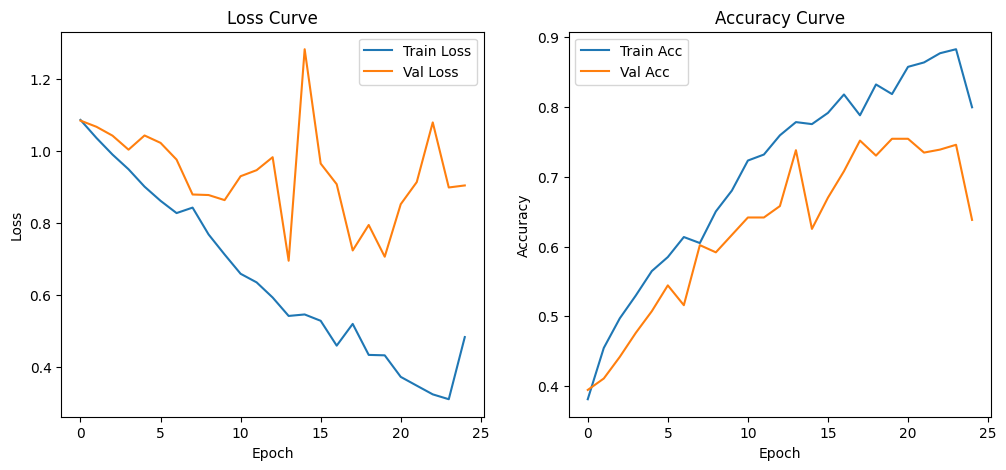

In [182]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

epochs = 25

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate_epoch(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Época {epoch+1:02} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

# Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for text, labels in test_loader:
        outputs = model(text)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matriz
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Inferência

Na inferência, é mandatório aplicar a mesma função `clean_tokenizer` utilizada no treino. Caracteres não alfabéticos devem ser removidos antes da consulta ao vocabulário para garantir a consistência da entrada do modelo.

In [ ]:
def predict(text, model, vocab, categories):
    model.eval()
    tokens = clean_tokenizer(text)
    indices = [vocab.get(t, vocab["<unk>"]) for t in tokens]
    
    if not indices:
        indices = [vocab["<unk>"]]
        
    tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax().item()
        
    return categories[pred_idx], probs.max().item()

# Exemplo
sample = "Here is a press release from Medical Science Communications.   Results of GUSTO Heart Attack Study to be Released Friday  To: Assignment Desk, Medical Writer  Contact: Jim Augustine of Medical Science"
pred_class, confidence = predict(sample, model, vocab, categories)

print(f"Entrada: {sample}")
print(f"Predição: {pred_class} ({confidence:.2%})")